# Image Based Machine Learning

- Use images from AIC API (extract around 5000 with the API) – maintain the link between artworks and their images
- Cluster them with ML methods (simple methods)
- Visualize results


In [6]:
import numpy as np
from PIL import Image
import requests
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from io import BytesIO
import csv
import time
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2


# Load data

In [16]:
API_URL = "https://api.artic.edu/api/v1/artworks"
IIIF_TEMPLATE = "https://www.artic.edu/iiif/2/{image_id}/full/843,/0/default.jpg"
# Parameters
FIELDS = ["id", "title", "artist_display", "image_id"]
LIMIT = 100  # max per page
TOTAL = 5000

In [17]:
def fetch_artworks():
    results = []
    page = 1
    collected = 0

    while collected < TOTAL:
        params = {
            "page": page,
            "limit": LIMIT,
            "fields": ",".join(FIELDS)
        }

        response = requests.get(API_URL, params=params)
        data = response.json()

        for artwork in data.get("data", []):
            image_id = artwork.get("image_id")
            if not image_id:
                continue  # skip entries without image

            image_url = IIIF_TEMPLATE.format(image_id=image_id)
            results.append({
                "id": artwork["id"],
                "title": artwork.get("title", ""),
                "artist": artwork.get("artist_display", ""),
                "image_url": image_url
            })

            collected += 1
            if collected >= TOTAL:
                break

        print(f"Collected {collected} artworks...")
        page += 1
        
        time.sleep(0.1)

    return results

In [18]:
artworks = fetch_artworks()

Collected 97 artworks...
Collected 183 artworks...
Collected 282 artworks...
Collected 380 artworks...
Collected 480 artworks...
Collected 580 artworks...
Collected 680 artworks...
Collected 780 artworks...
Collected 880 artworks...
Collected 979 artworks...
Collected 1079 artworks...
Collected 1179 artworks...
Collected 1277 artworks...
Collected 1376 artworks...
Collected 1476 artworks...
Collected 1576 artworks...
Collected 1676 artworks...
Collected 1774 artworks...
Collected 1874 artworks...
Collected 1973 artworks...
Collected 2071 artworks...
Collected 2171 artworks...
Collected 2264 artworks...
Collected 2344 artworks...
Collected 2430 artworks...
Collected 2522 artworks...
Collected 2616 artworks...
Collected 2704 artworks...
Collected 2803 artworks...
Collected 2903 artworks...
Collected 3001 artworks...
Collected 3100 artworks...
Collected 3200 artworks...
Collected 3300 artworks...
Collected 3400 artworks...
Collected 3499 artworks...
Collected 3599 artworks...
Collected 36

In [20]:
df = pd.DataFrame(artworks)

In [21]:
df.head()

,id,title,artist,image_url
0,255263,Sculpture,"Ernest Mancoba\nSouth African, 1904-2002",https://www.artic.edu/iiif/2/b6c60369-f3c6-336...
1,22,"Villa Pamphili outside Porta S. Pancrazio, fro...","Giovanni Battista Piranesi (Italian, 1720-1778...",https://www.artic.edu/iiif/2/a76844cc-cec8-602...
2,7988,Claude Monet,"Albert André (French, 1869-1954)",https://www.artic.edu/iiif/2/3dcb169e-b73e-6d5...
3,161,Skyphos (Drinking Cup),Greek; Athens,https://www.artic.edu/iiif/2/1bc27523-6b27-d9b...
4,9637,View of an Italian Villa and Gardens (the Belv...,"Jean Jacques de Boissieu\nFrench, 1736-1810",https://www.artic.edu/iiif/2/462c6fe2-40a4-ed8...


In [23]:
df = df.dropna(subset=["image_url"]).sample(1000, random_state=42).reset_index(drop=True)

# Download pictures

In [25]:
def load_and_preprocess_image(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((224, 224))
        arr = img_to_array(img)
        arr = preprocess_input(arr)  # VGG16 normalization
        return arr
    except:
        return None

images = []
valid_indices = []

for idx, url in tqdm(enumerate(df["image_url"]), total=len(df)):
    img = load_and_preprocess_image(url)
    if img is not None:
        images.append(img)
        valid_indices.append(idx)

images = np.array(images)
df = df.iloc[valid_indices].reset_index(drop=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


# Load/ Save Data

In [26]:
with open("images.pickle", "wb") as f:
    pickle.dump(images, f, protocol=pickle.HIGHEST_PROTOCOL)

with open("df.pickle", "wb") as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open("images.pickle", "rb") as f:
    images = pickle.load(f)

with open("df.pickle", "rb") as f:
    df = pickle.load(f)

# Run models

In [28]:
model_vgg = VGG16(weights="imagenet", include_top=False, pooling="avg")  # use global average pooling
features_vgg = model_vgg.predict(images, batch_size=32, verbose=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step


In [29]:
model_mobile_net = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
features_mobile_net = model_mobile_net.predict(images, batch_size=32, verbose=1)

C:\Users\bened\AppData\Local\Temp\ipykernel_15460\1431890465.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model_mobile_net = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step


# Compare results

In [30]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_vgg = tsne.fit_transform(features_vgg)

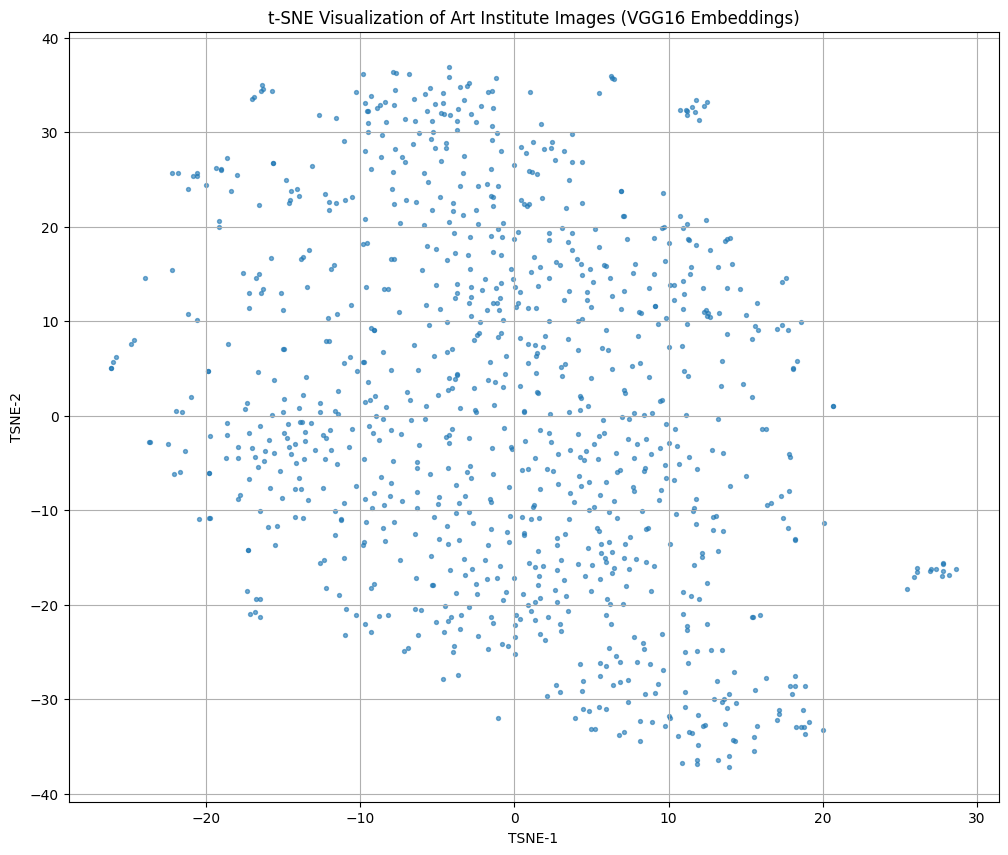

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter(reduced_vgg[:, 0], reduced_vgg[:, 1], s=8, alpha=0.6)
plt.title("t-SNE Visualization of Art Institute Images (VGG16 Embeddings)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()

In [32]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_mobile_net = tsne.fit_transform(features_mobile_net)

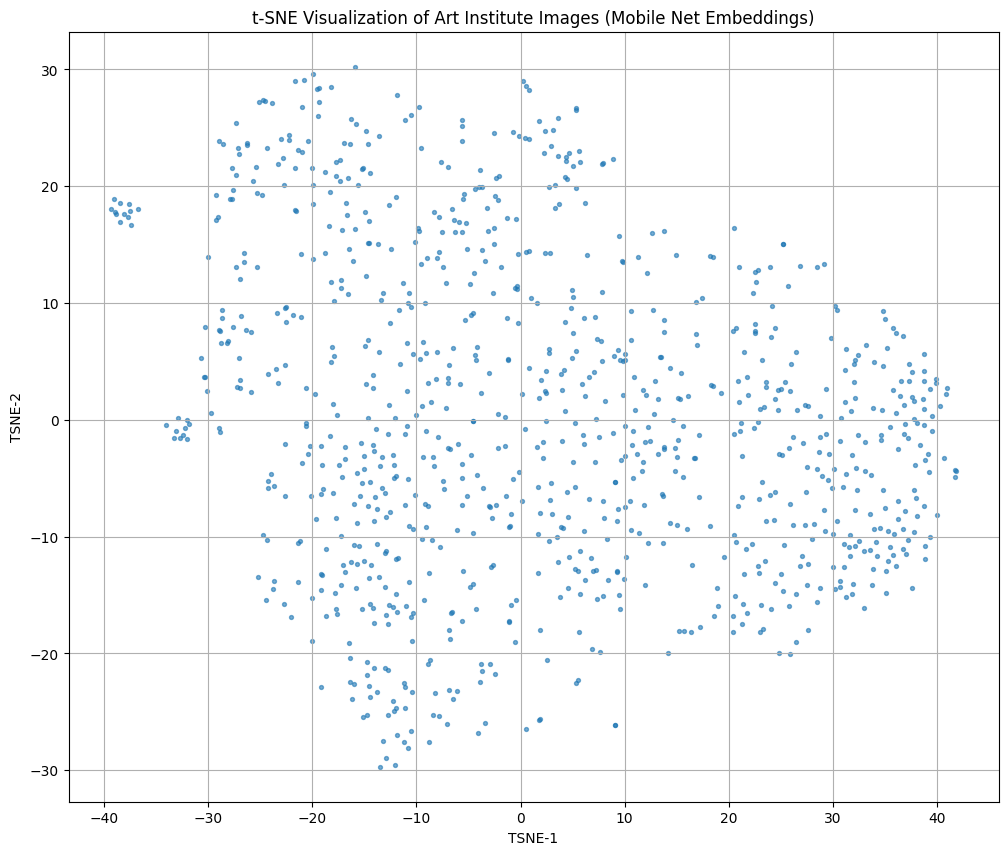

In [33]:
plt.figure(figsize=(12, 10))
plt.scatter(reduced_mobile_net[:, 0], reduced_mobile_net[:, 1], s=8, alpha=0.6)
plt.title("t-SNE Visualization of Art Institute Images (Mobile Net Embeddings)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()

In [34]:
# Load the model without the top classification layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobile = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Extract features
features_vgg = base_model_vgg.predict(images)  # Output shape: (n_images, 7, 7, 512)
features_flat_vgg = features_vgg.reshape(features_vgg.shape[0], -1)  # Flatten: shape (n_images, 25088)

# Extract features
features_mobile = base_model_mobile.predict(images)  # Output shape: (n_images, 7, 7, 512)
features_flat_mobile = features_mobile.reshape(features_mobile.shape[0], -1)  # Flatten: shape (n_images, 25088)

31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 229ms/step


# Cluster

In [35]:
kmeans = KMeans(n_clusters=5, random_state=0)

clusters_vgg = kmeans.fit_predict(features_flat_vgg)

df["cluster_vgg"] = clusters_vgg

clusters_mobile = kmeans.fit_predict(features_flat_mobile)

df["cluster_mobile"] = clusters_mobile

In [38]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(features_flat_vgg)

df["x"] = coords[:, 0]
df["y"] = coords[:, 1]

import plotly.express as px

df["hover_text"] = df.apply(
    lambda row: f"Title: {row['title']}Cluster: {row['cluster_vgg']}", axis=1
)

# Build the interactive scatter plot
fig = px.scatter(
    df,
    x="x", y="y",
    color="cluster_vgg",
    hover_name="hover_text",
    hover_data={"x": False, "y": False, "cluster_vgg": False},
    title="Artwork Clusters (t-SNE + VGG16 Features)",
    width=950,
    height=750
)

# Clean hover template — show only custom hover text, no extra info
fig.update_traces(hovertemplate="%{hovertext}")

import plotly.io as pio
pio.renderers.default = 'browser'

# Show plot
fig.show()

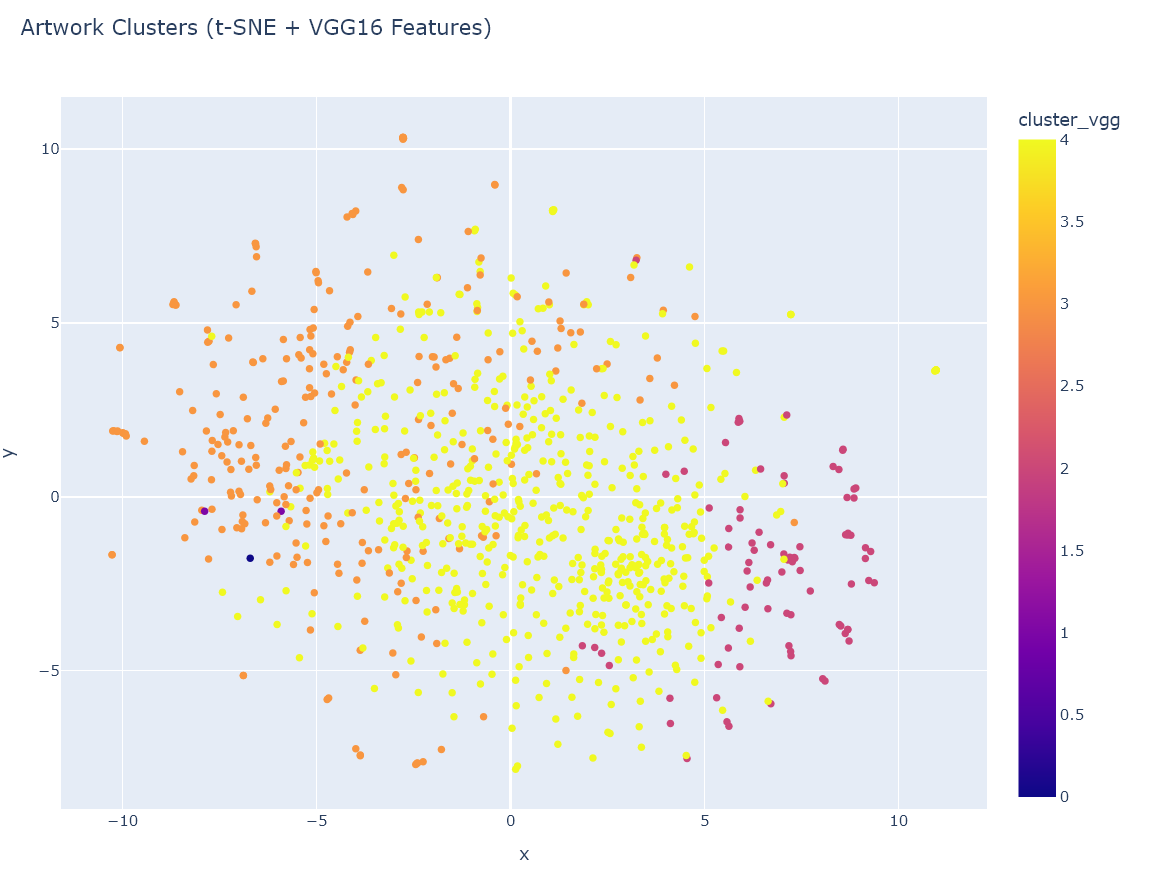

In [40]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(features_flat_mobile)

df["x"] = coords[:, 0]
df["y"] = coords[:, 1]

import plotly.express as px

df["hover_text"] = df.apply(
    lambda row: f"Title: {row['title']}Cluster: {row['cluster_mobile']}", axis=1
)

# Build the interactive scatter plot
fig = px.scatter(
    df,
    x="x", y="y",
    color="cluster_mobile",
    hover_name="hover_text",
    hover_data={"x": False, "y": False, "cluster_mobile": False},
    title="Artwork Clusters (t-SNE + Mobile Net Features)",
    width=950,
    height=750
)

# Clean hover template — show only custom hover text, no extra info
fig.update_traces(hovertemplate="%{hovertext}")

import plotly.io as pio
pio.renderers.default = 'browser'

# Show plot
fig.show()

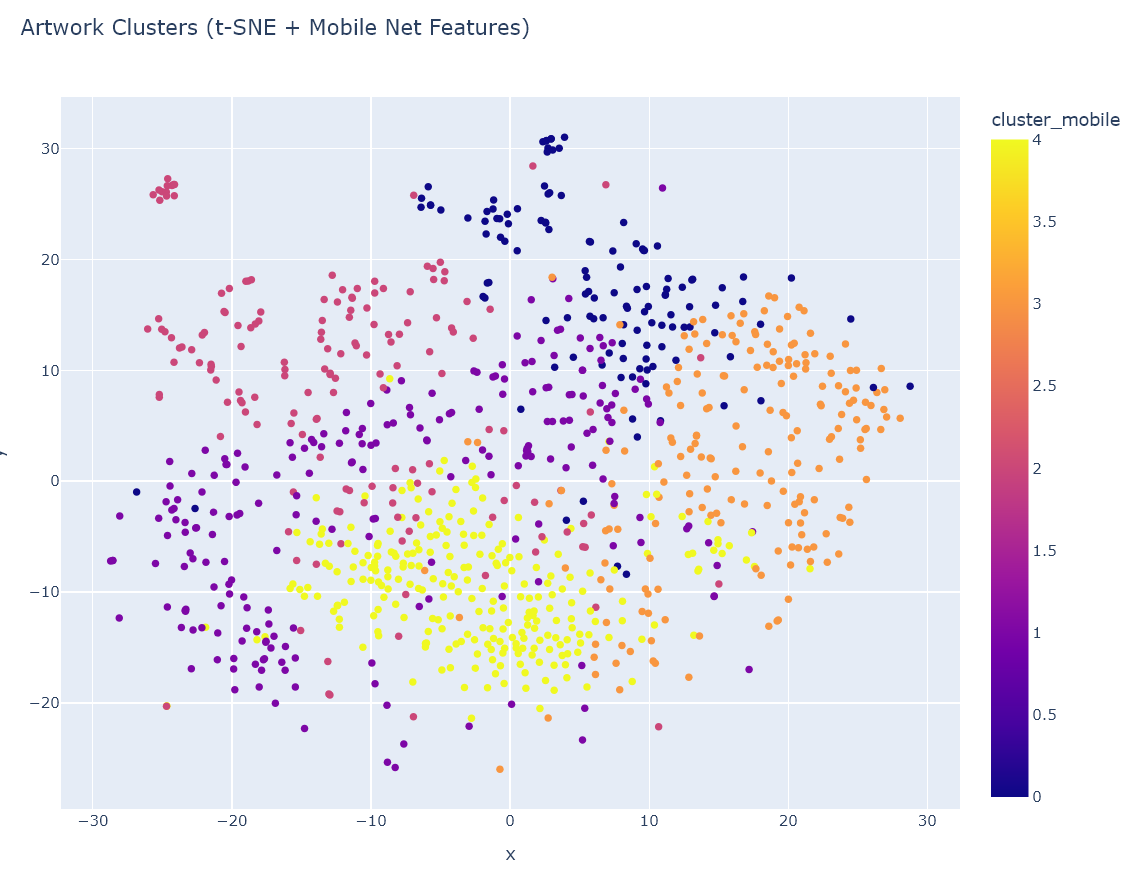

# Cluster content

## VGG

In [41]:
from IPython.display import display, Image, HTML

for cluster_id in sorted(df["cluster_vgg"].unique()):
    print(f"\n### Cluster {cluster_id} samples:\n")

    # Get the first 3 items from this cluster
    cluster_subset = df[df["cluster_vgg"] == cluster_id].head(3)

    for _, row in cluster_subset.iterrows():
        print(f"Title: {row['title']}")
        display(Image(url=row['image_url'], width=200))
        print("\n" + "*"*50)



### Cluster 0 samples:

Title: Bacchus



**************************************************

### Cluster 1 samples:

Title: Pygmalion and Galatea



**************************************************
Title: Neptune and Amphitrite, from Three Paired Gods and Goddesses



**************************************************

### Cluster 2 samples:

Title: Water Bottle (Kundika)



**************************************************
Title: Pair of Teacups



**************************************************
Title: Jug



**************************************************

### Cluster 3 samples:

Title: Self-Portrait (No. 17)



**************************************************
Title: Hat and Guitar, frontispiece for the edition of fourteen etchings



**************************************************
Title: Fourth Day: The Creation of the Sun, Moon, and Stars, from The Creation to the Expulsion from Paradise



**************************************************

### Cluster 4 samples:

Title: Little London Model



**************************************************
Title: La Buvette



**************************************************
Title: Ruth and Sam Ford House, number 1, Aurora, Illinois, Floor Plan



**************************************************


# Mobile Net

In [42]:
from IPython.display import display, Image, HTML

for cluster_id in sorted(df["cluster_mobile"].unique()):
    print(f"\n### Cluster {cluster_id} samples:\n")

    # Get the first 3 items from this cluster
    cluster_subset = df[df["cluster_mobile"] == cluster_id].head(3)

    for _, row in cluster_subset.iterrows():
        print(f"Title: {row['title']}")
        display(Image(url=row['image_url'], width=200))
        print("\n" + "*"*50)



### Cluster 0 samples:

Title: Self-Portrait (No. 17)



**************************************************
Title: Fourth Day: The Creation of the Sun, Moon, and Stars, from The Creation to the Expulsion from Paradise



**************************************************
Title: L’univers est créé (The Universe Is Being Created), from the Noa Noa Suite



**************************************************

### Cluster 1 samples:

Title: On the Bank of the Seine, Bennecourt



**************************************************
Title: October, from Twelve Months of Flowers



**************************************************
Title: The Property of John P. and Catharina Schuring, Franklin Town, Allegheny County, Pennsylvania



**************************************************

### Cluster 2 samples:

Title: Hat and Guitar, frontispiece for the edition of fourteen etchings



**************************************************
Title: Water Bottle (Kundika)



**************************************************
Title: Lapis Covered Dish on Stand



**************************************************

### Cluster 3 samples:

Title: Autumn Maples with Poem Slips



**************************************************
Title: The Return of the Prodigal Son, from The Parable of the Prodigal Son



**************************************************
Title: The Annunciation



**************************************************

### Cluster 4 samples:

Title: Little London Model



**************************************************
Title: La Buvette



**************************************************
Title: Ruth and Sam Ford House, number 1, Aurora, Illinois, Floor Plan



**************************************************
